In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Load best model

In [6]:
from jcopdl.layers import conv_block, linear_block

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16), 
            conv_block(16, 32),
            conv_block(32, 64),
            conv_block(64, 128), 
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(2048, 1024, dropout=0.2),
            linear_block(1024, 512, dropout=0.2),
            linear_block(512, 256, dropout=0.2),
            linear_block(256, 3, activation="lsoftmax")
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [8]:
weights = torch.load("model/weights_best.pth", map_location="cpu")
config = torch.load("model/configs.pth", map_location="cpu")
model = CNN()
model.load_state_dict(weights)
model = model.to(device)
model

CNN(
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel

In [21]:
from PIL import Image
from torch.autograd import Variable
import os

In [20]:
imsize = 128
##loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])
#loader = transforms.Compose([
#    transforms.Resize(140),
#    transforms.CenterCrop(imsize),
#    transforms.ToTensor()
#])
#
#def image_loader(image_name):
#    """load image, returns cuda tensor"""
#    image = Image.open(image_name)
#    image = loader(image).float()
#    image = Variable(image, requires_grad=True)
#    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
#    return image.cuda()  #assumes that you're using GPU
#
#image = image_loader('Sample/jpeg/Batu 7.jpeg')
#image.shape


torch.Size([1, 3, 128, 128])

In [39]:
bs = 128
crop_size = 128

test_transform = transforms.Compose([
    transforms.Resize(140),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

sample_set = datasets.ImageFolder("Sample/", transform=test_transform)
sampleloader = DataLoader(sample_set, batch_size=bs, shuffle=True)

In [40]:
feature, target = next(iter(sampleloader))
feature.shape

torch.Size([24, 3, 128, 128])

In [54]:
sample_set.classes

['paper', 'rock', 'scissors']

In [48]:
y = ['paper', 'rock', 'scissors']

In [42]:
with torch.no_grad():
    model.eval()
    output = model(feature.to(device))
    preds = output.argmax(1)
preds

tensor([0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       device='cuda:0')

In [53]:
preds

tensor([0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       device='cuda:0')

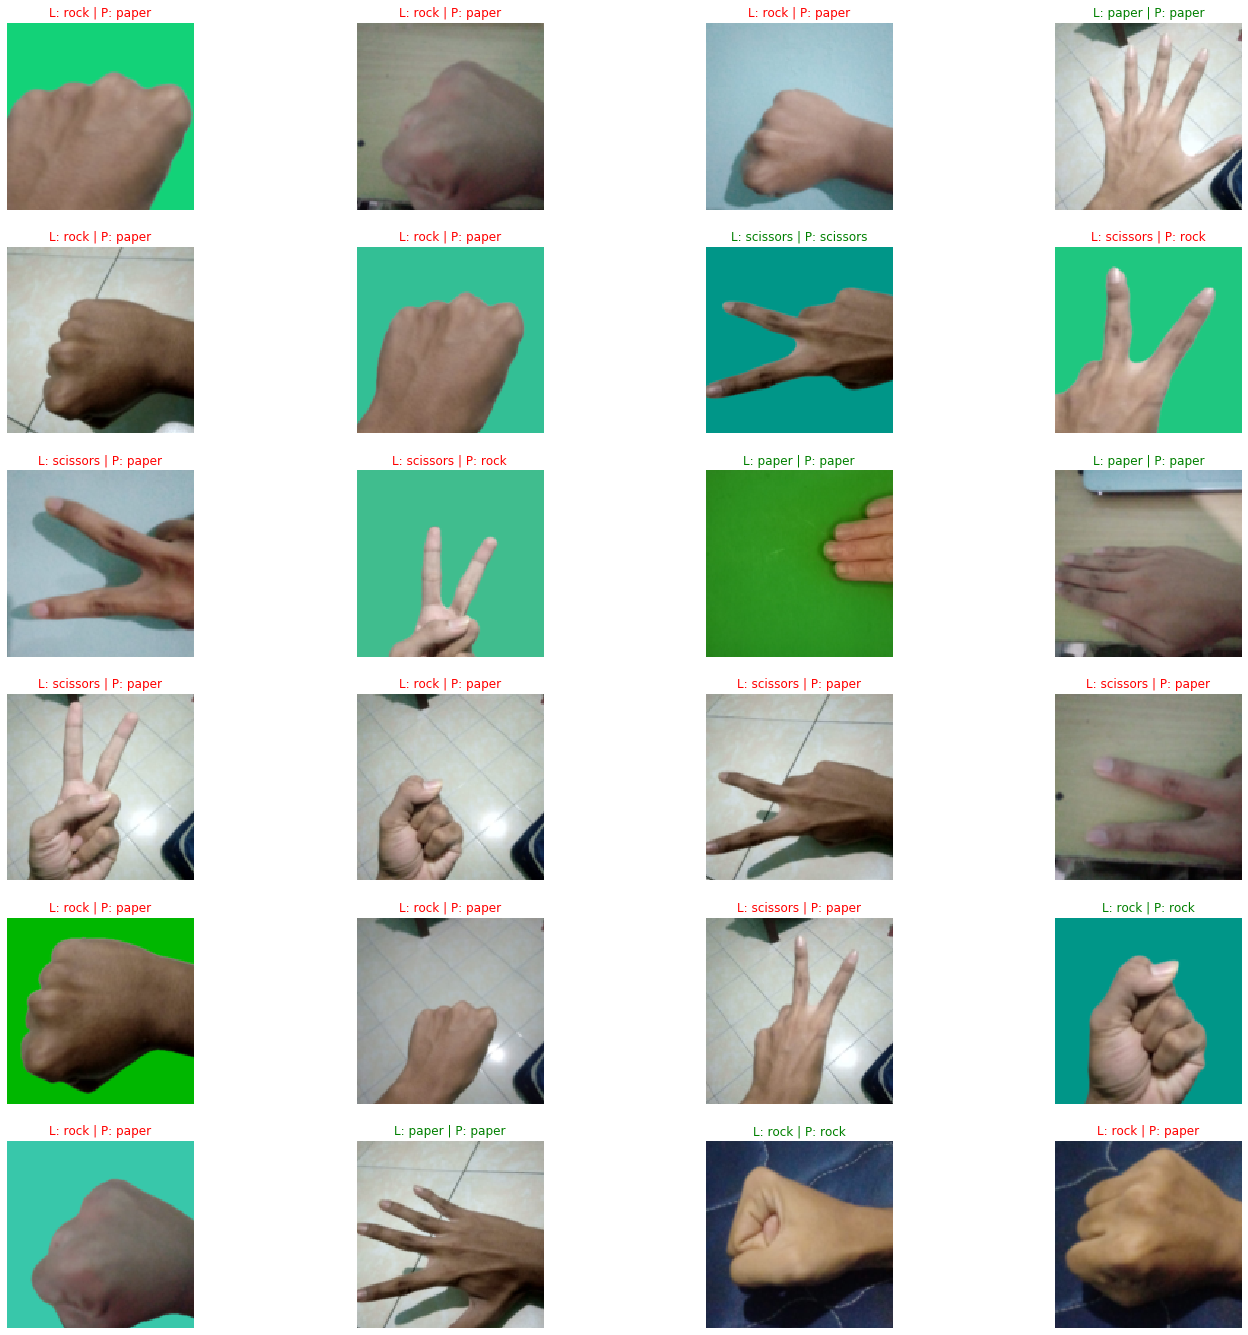

In [55]:
fig, axes = plt.subplots(6, 4, figsize=(24, 24))
for image, label, pred, ax in zip(feature.cpu(), target.cpu(), preds.cpu(), axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'g'}        
    label, pred = sample_set.classes[label.item()], sample_set.classes[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');

In [33]:
img[0].shape

torch.Size([1, 3, 128, 128])